Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
from sklearn.model_selection import train_test_split

In [295]:
train, val = train_test_split(train, train_size=.8, test_size=.2, random_state=42,)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
# wrangle funciton
def wrangle(X):

  X = X.copy()

  X['latitude'] = X['latitude'].replace(-2e-08)

  # cols with zeros
  cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                     'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  #duplicates
  duplicates = ['quantity_group', 'payment_type', 'water_quality', 
                'source_type', 'waterpoint_type_group','extraction_type_group',
                'extraction_type','management']
  X = X.drop(columns=duplicates)

  # drop unusable columns
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns=unusable_variance)

  # convert to datetime and create date columns
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  X['year_recorded'] = X['date_recorded'].dt.year 
  X['month_recorded'] = X['date_recorded'].dt.month 
  X['day_recorded'] = X['date_recorded'].dt.day 
  X = X.drop(columns = 'date_recorded')

  #engineer new features 
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_missing'] = X['years'].isnull()


  return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [298]:
train.shape, val.shape, test.shape

((47520, 40), (11880, 40), (14358, 39))

In [0]:
# feature engineering


In [0]:
import category_encoders as ce 
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
# x matrices and y vectors

target = 'status_group'

X_train = train.drop(columns = [target, 'construction_year'])
y_train = train[target]

X_val = val.drop(columns = [target, 'construction_year'])
y_val = val[target]

X_test = test.drop(columns = ['construction_year'])

In [301]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=150, max_features='auto', random_state=2,
                           n_jobs=-1,min_samples_leaf=2)
)
pipeline.fit(X_train, y_train)
print('Train Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Train Accuracy: 0.9480850168350168
Validation Accuracy: 0.8162457912457912


# Submission

In [0]:
submission = sample_submission
y_pred = pipeline.predict(X_test)
submission['status_group'] = y_pred

In [303]:
submission.to_csv('waterpump-submission-12.csv', index=False)
submission.shape

(14358, 2)

#Confusion Matrix and AUC

In [0]:
from sklearn.metrics import plot_confusion_matrix

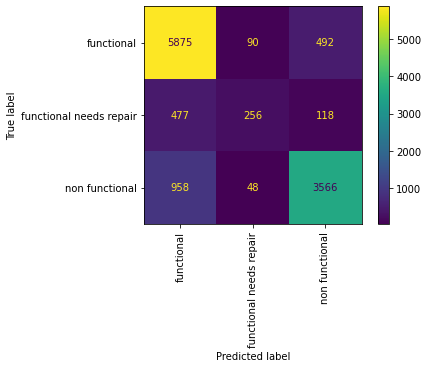

In [306]:
cm = plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')
cm;

In [0]:
from sklearn.metrics import classification_report

In [277]:
y_pred = pipeline.predict(X_val)
CR = classification_report(y_val, y_pred)
print(CR)

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6457
functional needs repair       0.65      0.30      0.41       851
         non functional       0.85      0.78      0.82      4572

               accuracy                           0.82     11880
              macro avg       0.77      0.66      0.69     11880
           weighted avg       0.81      0.82      0.81     11880



In [278]:
# predicted probabilities and plotting distributions
pipeline.predict_proba(X_val)

array([[3.10077519e-04, 6.66666667e-03, 9.93023256e-01],
       [7.37291123e-01, 1.59553104e-02, 2.46753567e-01],
       [8.08833333e-01, 7.41666667e-02, 1.17000000e-01],
       ...,
       [1.01010101e-02, 3.54256854e-03, 9.86356421e-01],
       [4.74292929e-01, 8.92698413e-02, 4.36437229e-01],
       [6.79501976e-01, 2.57740565e-01, 6.27574590e-02]])

In [279]:
# thresholding
threshold = 0.5
sum(pipeline.predict_proba(X_val)[:, 1] > threshold)

278

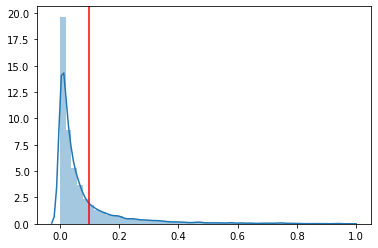

In [280]:
import seaborn as sns

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
ax = sns.distplot(y_pred_proba)
threshold = .1
ax.axvline(threshold, color='red');

In [0]:
#AUC
from sklearn.metrics import roc_curve, roc_auc_score

In [0]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

In [283]:
roc_auc_score(y_val, y_pred_proba)

0.483712590398229

In [0]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [285]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.972740
1,0.000000,0.000184,0.972740
2,0.000000,0.002028,0.931948
3,0.000155,0.002028,0.924375
4,0.000155,0.008851,0.781769
...,...,...,...
4747,0.947654,0.930850,0.000048
4748,0.947654,0.932510,0.000045
4749,0.950287,0.932510,0.000041
4750,0.950287,0.933432,0.000028


Text(0, 0.5, 'True Positive Rate')

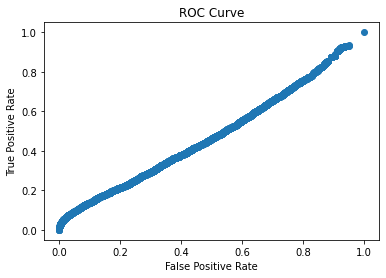

In [286]:
import matplotlib.pyplot as plt

plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Testing Model and Cross Validating


In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline,X_val, y_val, cv=2)

In [288]:
print ('Acuracy %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() *2))


Acuracy 0.78 (+/- 0.00)


In [0]:
# pipeline = make_pipeline(
#     ce.TargetEncoder(min_samples_leaf=4),
#     SimpleImputer(strategy='median'),
#     RandomForestClassifier(n_estimators=150, max_features='auto', random_state=2,
#                            n_jobs=-1,min_samples_leaf=2)
# )
# pipeline.fit(X_train, y_train)